# Sentiment Analysis using CNN

In [235]:
import pandas as pd
import numpy as np
import json

from collections import defaultdict
from pandas.api.types import is_numeric_dtype

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import nltk
from spacy.lang.en import English

from nltk import word_tokenize
import re
from keras.preprocessing.text import Tokenizer
from nltk.stem.porter import PorterStemmer
import tensorflow as tf 

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import keras
from keras.preprocessing.text import one_hot,Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense , Flatten ,Embedding,Input,CuDNNLSTM,LSTM
from keras.models import Model
from keras.preprocessing.text import text_to_word_sequence

import string
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences

#gensim w2v
#word2vec
import gensim
from gensim.models import Word2Vec

## Dataset

In [236]:
class Sentiment:
    NEGATIVE = "NEGATIVE"
    NEUTRAL = "NEUTRAL"
    POSITIVE = "POSITIVE"

class Review:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score <= 2:
            return Sentiment.NEGATIVE
        elif self.score == 3:
            return Sentiment.NEUTRAL
        else: #Score of 4 or 5
            return Sentiment.POSITIVE
        
        
file_name = '/Users/kritya/Downloads/Books_large.json'

reviews = []
with open(file_name) as f:
    for line in f:
        review = json.loads(line)
        reviews.append(Review(review["reviewText"], review["overall"]))
        
print('Review : \n', reviews[0].text)
print('Sentiment :', reviews[0].sentiment)

Review : 
 I bought both boxed sets, books 1-5.  Really a great series!  Start book 1 three weeks ago and just finished book 5.  Sloane Monroe is a great character and being able to follow her through both private life and her PI life gets a reader very involved!  Although clues may be right in front of the reader, there are twists and turns that keep one guessing until the last page!  These are books you won't be disappointed with.
Sentiment : POSITIVE


In [237]:
class ReviewContainer:
    def __init__(self, reviews):
        self.reviews = reviews
        
    def get_text(self):
        return [x.text for x in self.reviews]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.reviews]
    
    def evenly_distribute(self):
        negative = list(filter(lambda x: x.sentiment == Sentiment.NEGATIVE, self.reviews))
        positive = list(filter(lambda x: x.sentiment == Sentiment.POSITIVE, self.reviews))
        neutral = list(filter(lambda x: x.sentiment == Sentiment.NEUTRAL, self.reviews))
        positive_shrunk = positive[:len(negative)]
        neutral_shrunk = neutral[:len(negative)]
        self.reviews = negative + positive_shrunk + neutral_shrunk
        np.random.shuffle(self.reviews)

In [238]:
reviews_container = ReviewContainer(reviews)

#reviews_container.evenly_distribute()
text = reviews_container.get_text()
sentiment = reviews_container.get_sentiment()

In [239]:
Dataset = pd.DataFrame({
    'Reviews':text,
    'Sentiment':sentiment
})

In [240]:
Dataset

,Reviews,Sentiment
0,"I bought both boxed sets, books 1-5. Really a...",POSITIVE
1,I enjoyed this short book. But it was way way ...,NEUTRAL
2,I love Nicholas Sparks. I&#8217;ve read everyt...,POSITIVE
3,I really enjoyed this adventure and look forwa...,POSITIVE
4,It was a decent read.. typical story line. Not...,NEUTRAL
...,...,...
9995,The whole series was great! Melody is a fanta...,POSITIVE
9996,I didn't thing that much of this book. I am a...,NEUTRAL
9997,It is an emotional TRIP to the past with Trip ...,POSITIVE
9998,This definitely got under my veins whereby I h...,POSITIVE


# 

# 

# CNN with GloVe

In [356]:
Dataset

,Reviews,Sentiment,clean_review,Label
0,"I bought both boxed sets, books 1-5. Really a...",POSITIVE,bought boxed set book really great series star...,2
1,I enjoyed this short book. But it was way way ...,NEUTRAL,enjoyed short book way way short see easily wo...,1
2,I love Nicholas Sparks. I&#8217;ve read everyt...,POSITIVE,love nicholas spark read everything written wa...,2
3,I really enjoyed this adventure and look forwa...,POSITIVE,really enjoyed adventure look forward reading ...,2
4,It was a decent read.. typical story line. Not...,NEUTRAL,decent read typical story line nothing unsavor...,1
...,...,...,...,...
9995,The whole series was great! Melody is a fanta...,POSITIVE,whole series great melody fantastic writer kee...,2
9996,I didn't thing that much of this book. I am a...,NEUTRAL,thing much book boater lot going boat seem rea...,1
9997,It is an emotional TRIP to the past with Trip ...,POSITIVE,emotional trip past trip layla love ease writi...,2
9998,This definitely got under my veins whereby I h...,POSITIVE,definitely got vein whereby purchase related b...,2


In [357]:
from sklearn.model_selection import train_test_split

train_size = 0.60
val_size = 0.20
test_size = 0.20

X = Dataset['Reviews']
y = Dataset['Label']

# Split (train)
X_train, X_, y_train, y_ = train_test_split(X, y, train_size=train_size)
# Split (test and val)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.5, random_state = 45)

print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"val: {len(X_val)} ({len(X_val)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

train: 6000 (0.60)
val: 2000 (0.20)
test: 2000 (0.20)


In [358]:
# max length of review calculation
maxi=-1
for i,rev in enumerate(Dataset['clean_review']):
    tokens=rev.split()
    if(len(tokens)>maxi):
        maxi=len(tokens)
print(maxi)

476


In [359]:
#Tokenize
from keras.preprocessing.text import Tokenizer

tok = Tokenizer()
tok.fit_on_texts(Dataset['clean_review'])
words_to_index = tok.word_index
encd_rev = tok.texts_to_sequences(Dataset['clean_review'])

In [360]:
len(words_to_index)

27364

In [361]:
max_rev_len=476  # max lenght of a review
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=50

In [362]:
from keras.preprocessing.sequence import pad_sequences
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')
pad_rev.shape 

(10000, 476)

In [363]:
# GloVe

def read_glove_vector(glove_vec):
    with open(glove_vec, 'r', encoding='UTF-8') as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            w_line = line.split()
            curr_word = w_line[0]
            word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
    return word_to_vec_map

In [364]:
word_to_vec_map = read_glove_vector('/Users/kritya/Downloads/glove/glove.6B.50d.txt')

In [365]:
maxLen = max_rev_len

In [366]:
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Conv1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from keras.models import Model
import string
from sklearn.preprocessing import LabelBinarizer
from keras.preprocessing.sequence import pad_sequences
import keras
from sklearn.model_selection import train_test_split

In [367]:
vocab_len = len(words_to_index)+1
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [368]:
def conv1d_model_glove(input_shape):

    X_indices = Input(input_shape)

    embeddings = embedding_layer(X_indices)

    X = Conv1D(512,1,activation='relu')(embeddings)
  
    X = MaxPooling1D(1)(X)

    X = Conv1D(256,1,activation='relu')(X)
  
    X = MaxPooling1D(1)(X)

    X = Conv1D(256,1,activation='relu')(X)
    X = Dropout(0.8)(X)
    X = MaxPooling1D(1)(X)

    X = GlobalMaxPooling1D()(X)

    X = Dense(256, activation='relu')(X)
    X = Dense(3, activation='sigmoid')(X)

    model = Model(inputs=X_indices, outputs=X)

    return model

In [369]:
model_glove = conv1d_model_glove((maxLen,))
model_glove.summary()

Model: "model_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_32 (InputLayer)       [(None, 476)]             0         
                                                                 
 embedding_18 (Embedding)    (None, 476, 50)           1368250   
                                                                 
 conv1d_65 (Conv1D)          (None, 476, 512)          26112     
                                                                 
 max_pooling1d_41 (MaxPoolin  (None, 476, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_66 (Conv1D)          (None, 476, 256)          131328    
                                                                 
 max_pooling1d_42 (MaxPoolin  (None, 476, 256)         0         
 g1D)                                                     

In [370]:
import tensorflow as tf 
adam = tf.optimizers.Adam(learning_rate = 0.0001)
model_glove.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [371]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
tokenizer = Tokenizer()
X_train_indices = tokenizer.texts_to_sequences(X_train)

In [372]:
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen)
X_train_indices.shape

(6000, 476)

In [373]:
%%time

Glove_hist = model_glove.fit(X_train_indices, y_train, batch_size=128, epochs=10)

Epoch 1/10
47/47 [==============================] - 48s 993ms/step - loss: 1.0964 - accuracy: 0.8165
Epoch 2/10
47/47 [==============================] - 47s 995ms/step - loss: 1.0917 - accuracy: 0.8342
Epoch 3/10
47/47 [==============================] - 50s 1s/step - loss: 1.0871 - accuracy: 0.8342
Epoch 4/10
47/47 [==============================] - 72s 2s/step - loss: 1.0825 - accuracy: 0.8342
Epoch 5/10
47/47 [==============================] - 54s 1s/step - loss: 1.0779 - accuracy: 0.8342
Epoch 6/10
47/47 [==============================] - 57s 1s/step - loss: 1.0733 - accuracy: 0.8342
Epoch 7/10
47/47 [==============================] - 60s 1s/step - loss: 1.0688 - accuracy: 0.8342
Epoch 8/10
47/47 [==============================] - 61s 1s/step - loss: 1.0643 - accuracy: 0.8342
Epoch 9/10
47/47 [==============================] - 62s 1s/step - loss: 1.0599 - accuracy: 0.8342
Epoch 10/10
47/47 [==============================] - 65s 1s/step - loss: 1.0554 - accuracy: 0.8342
CPU times: us

In [374]:
X_test_indices = tokenizer.texts_to_sequences(X_test)

X_test_indices = pad_sequences(X_test_indices, maxlen=maxLen, padding='post')

In [375]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model_glove.predict(X_test_indices, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

32/32 [==============================] - 4s 117ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       116
           1       0.00      0.00      0.00       189
           2       0.85      1.00      0.92      1695

    accuracy                           0.85      2000
   macro avg       0.28      0.33      0.31      2000
weighted avg       0.72      0.85      0.78      2000



/Users/kritya/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


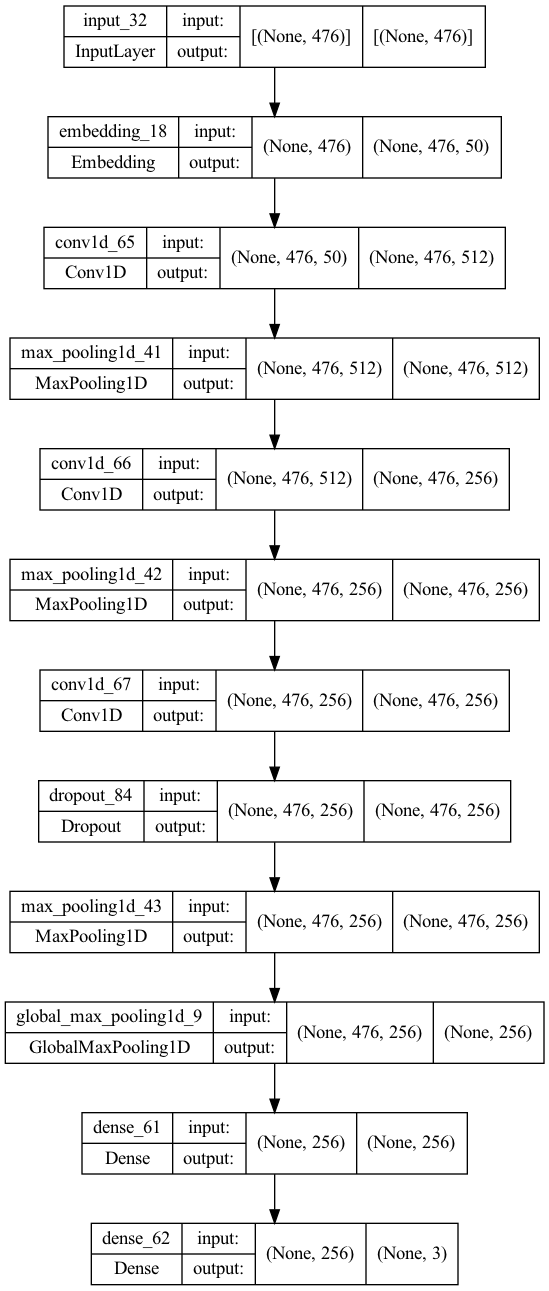

In [376]:
tf.keras.utils.plot_model(model_glove, "multi_input_and_output_model.png", show_shapes=True)

# with word2vec

In [377]:
import gensim
w2v_model=gensim.models.Word2Vec(sentences=sentences,vector_size=300,window=10,min_count=1)

w2v_model.train(sentences,epochs=10,total_examples=len(sentences))

vocab=w2v_model.wv.key_to_index
print("The total number of words are : ",len(vocab))

vocab=list(vocab.keys())

word_vec_dict={}
for word in vocab:
    word_vec_dict[word]=w2v_model.wv.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict)) 

maxi=-1
for i,rev in enumerate(Dataset['clean_review']):
    tokens=rev.split()
    if(len(tokens)>maxi):
        maxi=len(tokens)
print(maxi)

tok = Tokenizer()
tok.fit_on_texts(Dataset['clean_review'])
vocab_size = len(tok.word_index) + 1
encd_rev = tok.texts_to_sequences(Dataset['clean_review'])

max_rev_len=476  # max lenght of a review
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=300

from keras.preprocessing.sequence import pad_sequences
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')
pad_rev.shape

# now creating the embedding matrix
embed_matrix=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tok.word_index.items():
    embed_vector=word_vec_dict.get(word)
    if embed_vector is not None:  # word is in the vocabulary learned by the w2v model
        embed_matrix[i]=embed_vector

from sklearn.model_selection import train_test_split

Y=Dataset['Label']  # one hot target as required by NN.
x_train,x_test,y_train,y_test=train_test_split(pad_rev,Y,test_size=0.20,random_state=35)

The total number of words are :  27364
The no of key-value pairs :  27364
476


In [378]:
embedding_layer = Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=max_rev_len,embeddings_initializer=Constant(embed_matrix))


In [379]:
def conv1d_model_w2v(input_shape):

    X_indices = Input(input_shape)

    embeddings = embedding_layer(X_indices)

    X = Conv1D(512,1,activation='relu')(embeddings)
  
    X = MaxPooling1D(1)(X)

    X = Conv1D(256,1,activation='relu')(X)
  
    X = MaxPooling1D(1)(X)

    X = Conv1D(256,1,activation='relu')(X)
    X = Dropout(0.8)(X)
    X = MaxPooling1D(1)(X)

    X = GlobalMaxPooling1D()(X)

    X = Dense(256, activation='relu')(X)
    X = Dense(3, activation='sigmoid')(X)

    model = Model(inputs=X_indices, outputs=X)

    return model

In [380]:
model_W2V = conv1d_model_w2v((maxLen,))
model_W2V.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 476)]             0         
                                                                 
 embedding_19 (Embedding)    (None, 476, 300)          8209500   
                                                                 
 conv1d_68 (Conv1D)          (None, 476, 512)          154112    
                                                                 
 max_pooling1d_44 (MaxPoolin  (None, 476, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_69 (Conv1D)          (None, 476, 256)          131328    
                                                                 
 max_pooling1d_45 (MaxPoolin  (None, 476, 256)         0         
 g1D)                                                     

In [381]:
import tensorflow as tf 
adam = tf.optimizers.Adam(learning_rate = 0.0001)
model_W2V.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [382]:
W2V_hist = model_W2V.fit(x_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
63/63 [==============================] - 114s 2s/step - loss: 0.5572 - accuracy: 0.8334
Epoch 2/10
63/63 [==============================] - 113s 2s/step - loss: 0.4919 - accuracy: 0.8385
Epoch 3/10
63/63 [==============================] - 143s 2s/step - loss: 0.4668 - accuracy: 0.8393
Epoch 4/10
63/63 [==============================] - 137s 2s/step - loss: 0.4475 - accuracy: 0.8380
Epoch 5/10
63/63 [==============================] - 165s 3s/step - loss: 0.4431 - accuracy: 0.8465
Epoch 6/10
63/63 [==============================] - 154s 2s/step - loss: 0.4319 - accuracy: 0.8438
Epoch 7/10
63/63 [==============================] - 177s 3s/step - loss: 0.4226 - accuracy: 0.8461
Epoch 8/10
63/63 [==============================] - 183s 3s/step - loss: 0.4206 - accuracy: 0.8479
Epoch 9/10
63/63 [==============================] - 197s 3s/step - loss: 0.4124 - accuracy: 0.8505
Epoch 10/10
63/63 [==============================] - 173s 3s/step - loss: 0.4073 - accuracy: 0.8500


In [383]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model_W2V.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

32/32 [==============================] - 10s 198ms/step
              precision    recall  f1-score   support

           0       0.31      0.24      0.27       140
           1       0.27      0.18      0.22       207
           2       0.87      0.93      0.90      1653

    accuracy                           0.80      2000
   macro avg       0.49      0.45      0.46      2000
weighted avg       0.77      0.80      0.79      2000



# With unique embeddings


In [384]:
from sklearn.model_selection import train_test_split

train_size = 0.60
val_size = 0.20
test_size = 0.20

X = Dataset['Reviews']
y = Dataset['Label']

# Split (train)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.80)
# Split (test and val)

print(f"train: {len(X_train)} ({len(X_train)/len(X):.2f})\n"
      f"test: {len(X_test)} ({len(X_test)/len(X):.2f})")

# max length of review calculation
maxi=-1
for i,rev in enumerate(Dataset['clean_review']):
    tokens=rev.split()
    if(len(tokens)>maxi):
        maxi=len(tokens)
print(maxi)

train: 8000 (0.80)
test: 2000 (0.20)
476


In [385]:
#Tokenize
from keras.preprocessing.text import Tokenizer

from tqdm import tqdm
# keras tokenzier initialization
unique_words = set()
len_max = 0
for sent in tqdm(x_train):
    unique_words.update(sent)
    if len_max < len(sent):
        len_max = len(sent)
len(list(unique_words)), len_max

wor_len = len(list(unique_words))

tok = Tokenizer(num_words=wor_len)
tok.fit_on_texts(Dataset['clean_review'])
words_to_index = tok.word_index
encd_rev = tok.texts_to_sequences(Dataset['clean_review'])

len(words_to_index)

100%|██████████| 8000/8000 [00:00<00:00, 8886.47it/s]


27364

In [386]:
max_rev_len=476  # max lenght of a review
vocab_size = len(tok.word_index) + 1  # total no of words
embed_dim=50

from keras.preprocessing.sequence import pad_sequences
pad_rev= pad_sequences(encd_rev, maxlen=max_rev_len, padding='post')
pad_rev.shape 

(10000, 476)

In [387]:
vocab_len = len(words_to_index)+1
embed_vector_len = 50

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
    embedding_vector = word_to_vec_map.get(word)
    if embedding_vector is not None:
        emb_matrix[index, :] = embedding_vector

embedding_layer = Embedding(input_dim=vocab_len, output_dim=embed_vector_len, input_length=maxLen, weights = [emb_matrix], trainable=False)

In [388]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
tokenizer = Tokenizer()
X_train_indices = tokenizer.texts_to_sequences(X_train)
X_train_indices = pad_sequences(X_train_indices, maxlen=maxLen)
X_train_indices.shape


(8000, 476)

In [389]:
def conv1d_model_without_embeddings(input_shape):

    X_indices = Input(input_shape)

    embeddings = embedding_layer(X_indices)

    X = Conv1D(512,1,activation='relu')(embeddings)
  
    X = MaxPooling1D(1)(X)

    X = Conv1D(256,1,activation='relu')(X)
  
    X = MaxPooling1D(1)(X)

    X = Conv1D(256,1,activation='relu')(X)
    X = Dropout(0.8)(X)
    X = MaxPooling1D(1)(X)

    X = GlobalMaxPooling1D()(X)

    X = Dense(256, activation='relu')(X)
    X = Dense(3, activation='sigmoid')(X)

    model = Model(inputs=X_indices, outputs=X)
    
    return model

In [390]:
model_WE = conv1d_model_without_embeddings((maxLen,))
model_WE.summary()

Model: "model_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_34 (InputLayer)       [(None, 476)]             0         
                                                                 
 embedding_20 (Embedding)    (None, 476, 50)           1368250   
                                                                 
 conv1d_71 (Conv1D)          (None, 476, 512)          26112     
                                                                 
 max_pooling1d_47 (MaxPoolin  (None, 476, 512)         0         
 g1D)                                                            
                                                                 
 conv1d_72 (Conv1D)          (None, 476, 256)          131328    
                                                                 
 max_pooling1d_48 (MaxPoolin  (None, 476, 256)         0         
 g1D)                                                     

In [391]:
import tensorflow as tf 
adam = tf.optimizers.Adam(learning_rate = 0.0001)
model_WE.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [392]:
WE_hist = model_WE.fit(x_train, y_train, batch_size=128, epochs=10)

Epoch 1/10
63/63 [==============================] - 149s 2s/step - loss: 0.5939 - accuracy: 0.8296
Epoch 2/10
63/63 [==============================] - 136s 2s/step - loss: 0.5578 - accuracy: 0.8385
Epoch 3/10
63/63 [==============================] - 140s 2s/step - loss: 0.5599 - accuracy: 0.8388
Epoch 4/10
63/63 [==============================] - 137s 2s/step - loss: 0.5540 - accuracy: 0.8386
Epoch 5/10
63/63 [==============================] - 136s 2s/step - loss: 0.5522 - accuracy: 0.8388
Epoch 6/10
63/63 [==============================] - 102s 2s/step - loss: 0.5517 - accuracy: 0.8388
Epoch 7/10
63/63 [==============================] - 121s 2s/step - loss: 0.5521 - accuracy: 0.8388
Epoch 8/10
63/63 [==============================] - 97s 2s/step - loss: 0.5477 - accuracy: 0.8388
Epoch 9/10
63/63 [==============================] - 111s 2s/step - loss: 0.5440 - accuracy: 0.8388
Epoch 10/10
63/63 [==============================] - 116s 2s/step - loss: 0.5451 - accuracy: 0.8388


In [393]:
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

y_pred = model_WE.predict(x_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

32/32 [==============================] - 4s 125ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       124
           1       0.00      0.00      0.00       208
           2       0.83      1.00      0.91      1668

    accuracy                           0.83      2000
   macro avg       0.28      0.33      0.30      2000
weighted avg       0.70      0.83      0.76      2000



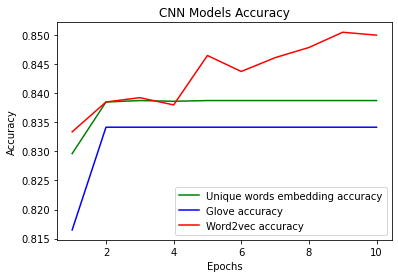

In [397]:
withoutemm = WE_hist.history['accuracy']
glove = Glove_hist.history['accuracy']
word2vec = W2V_hist.history['accuracy']
epochs = range(1,11)
plt.plot(epochs, withoutemm, 'g', label='Unique words embedding accuracy')
plt.plot(epochs, glove, 'b', label='Glove accuracy')
plt.plot(epochs, word2vec, 'r', label='Word2vec accuracy')
plt.title('CNN Models Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()